In [50]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
import numpy as np
import sklearn
import sklearn.model_selection
import sklearn.metrics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize
import time
import pathlib
from pathlib import Path

np.random.seed(100)

sns.set()
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['savefig.dpi'] = 120

In [113]:
from models import LaplaceLogisticClassifier, LogisticClassifier
from models import logistic_log_likelihood, logistic_ll_hessian
from util import split_data, transform_to_rbf, logistic, log_likelihood, hard_prediction, confusion_matrix_norm
from plot_util import plot_data, plot_predictive_contourf, plot_predictive_distribution

In [114]:
savedir = Path('plots/ftr')

(-3, 2)

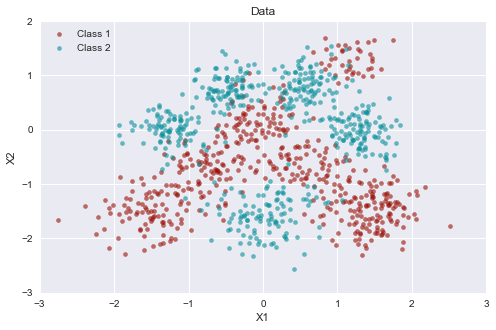

In [115]:
# Load data
x = np.loadtxt('X.txt')
y = np.loadtxt('y.txt')
plot_data(x, y, ax=None)
plt.xlim(-3, 3)
plt.ylim(-3, 2)

#### Train / Test Split and Transform to RBF

In [116]:
rbf_width = 0.1
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=200, random_state=42069)
radial_basis = x_train
x_train_rbf, x_test_rbf, x_rbf = map(lambda x: transform_to_rbf(x, radial_basis, width=rbf_width, add_bias_term=True),
                                     [x_train, x_test, x])

#### Fit the parameters

In [117]:
model = LaplaceLogisticClassifier(input_size=x_train_rbf.shape[1], prior_var=1.)
model.fit_map(x_train_rbf, y_train)

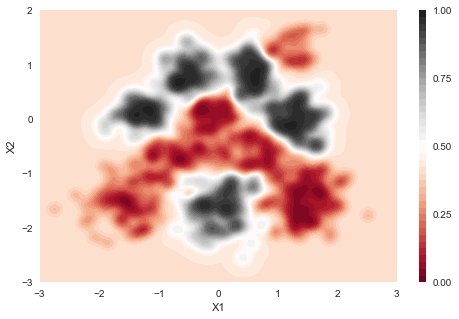

In [118]:
map_classifier = LogisticClassifier(input_size=x_train_rbf.shape[1])
map_classifier.weights = model.weights_map
# map_classifier.compute_avg_ll(x_train_rbf, y_train)
plot_predictive_contourf(predict_func=lambda x: map_classifier.predict(transform_to_rbf(x, radial_basis, rbf_width)),
                        xrange=(-3, 3), yrange=(-3, 2), res=300)
plt.savefig(str(savedir/'map_contourf_rbf01_var1.png'), bbox_inches='tight')

In [119]:
# Fit the Laplace Approximation
model.fit_laplace_approx(x_train_rbf, y_train)

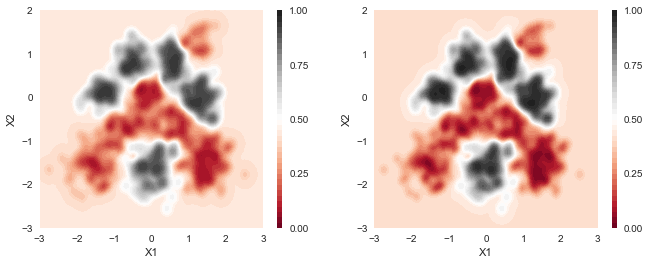

In [120]:
# Plot the two predictive distributions side by side
res = 100
fig, axes = plt.subplots(ncols=2, figsize=(11, 4))
plot_predictive_contourf(predict_func=lambda x: model.bayesian_predict(transform_to_rbf(x, radial_basis, rbf_width)),
                         xrange=(-3, 3), yrange=(-3, 2), res=res,  ax=axes[0])
plot_predictive_contourf(predict_func=lambda x: map_classifier.predict(transform_to_rbf(x, radial_basis, rbf_width)),
                        xrange=(-3, 3), yrange=(-3, 2), res=res, ax=axes[1])

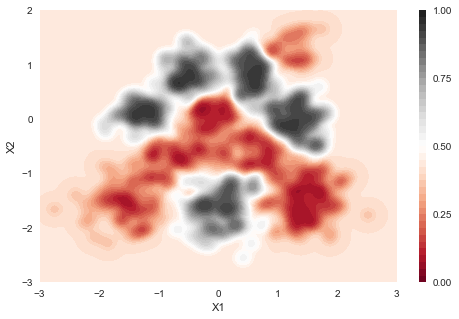

In [121]:
res = 300
# fig, axes = plt.subplots(ncols=2, figsize=(11, 4))
plot_predictive_contourf(predict_func=lambda x: model.bayesian_predict(transform_to_rbf(x, radial_basis, rbf_width)),
                         xrange=(-3, 3), yrange=(-3, 2), res=res)
plt.savefig(str(savedir/'bayes_contourf_rbf01_var1.png'), bbox_inches='tight')

(<matplotlib.axes._subplots.AxesSubplot at 0x1b21371ef0>, (-3, 3), (-3, 2))

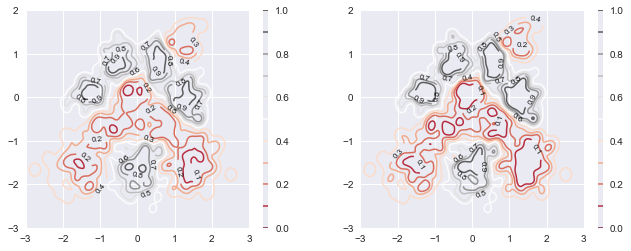

In [122]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 4))
plot_predictive_distribution(predict_func=lambda x: model.bayesian_predict(transform_to_rbf(x, radial_basis, rbf_width)),
                         xrange=(-3, 3), yrange=(-3, 2), res=res,  ax=axes[0])
plot_predictive_distribution(predict_func=lambda x: map_classifier.predict(transform_to_rbf(x, radial_basis, rbf_width)),
                        xrange=(-3, 3), yrange=(-3, 2), res=res, ax=axes[1])

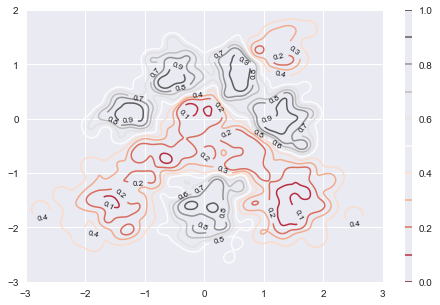

In [123]:
plot_predictive_distribution(predict_func=lambda x: model.bayesian_predict(transform_to_rbf(x, radial_basis, rbf_width)),
                         xrange=(-3, 3), yrange=(-3, 2), res=res)
plt.savefig(str(savedir/'bayes_contour_rbf01_var1.png'), bbox_inches='tight')


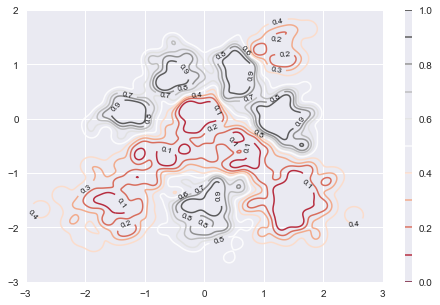

In [124]:
plot_predictive_distribution(predict_func=lambda x: map_classifier.predict(transform_to_rbf(x, radial_basis, rbf_width)),
                        xrange=(-3, 3), yrange=(-3, 2), res=res)
plt.savefig(str(savedir/'map_contour_rbf01_var1.png'), bbox_inches='tight')


In [125]:
print(model.calc_evidence(x_train_rbf, y_train))
print(model.calc_evidence(x_test_rbf, y_test))

(-319.8790844210705, 1.1975089271549759e-139)
(-204.77711909046033, 1.1652715919784406e-89)


In [126]:
# Calculate the confusion matrices for MAP and Bayesian models
y_probs_map = map_classifier.predict(x_test_rbf)
y_probs_bayes = model.bayesian_predict(x_test_rbf)
y_pred_map = hard_prediction(y_probs_bayes)
y_pred_bayes = hard_prediction(y_probs_map)
confusion_mat_map = confusion_matrix_norm(y_test, y_pred_map)

confusion_mat_bayes = confusion_matrix_norm(y_test, y_pred_bayes)
print(confusion_mat_map, '\n\n', confusion_mat_bayes)
# And the log-likelihoods
avg_ll_map = np.mean(log_likelihood(y_test, y_probs_map))
avg_ll_bayes = np.mean(log_likelihood(y_test, y_probs_bayes))
print(f"Avg. test log-likelihood:\n  MAP: {avg_ll_map}\n  Bayes: {avg_ll_bayes}")


[[0.875      0.125     ]
 [0.06818182 0.93181818]] 

 [[0.875      0.125     ]
 [0.06818182 0.93181818]]
Avg. test log-likelihood:
  MAP: -0.3078372939723588
  Bayes: -0.33391849237079235


In [127]:
# Calculate the confusion matrices for MAP and Bayesian models
y_probs_map = map_classifier.predict(x_train_rbf)
y_probs_bayes = model.bayesian_predict(x_train_rbf)
y_pred_map = hard_prediction(y_probs_bayes)
y_pred_bayes = hard_prediction(y_probs_map)

# And the log-likelihoods
avg_ll_map = np.mean(log_likelihood(y_train, y_probs_map))
avg_ll_bayes = np.mean(log_likelihood(y_train, y_probs_bayes))

print(f"Avg. train log-likelihood:\n  MAP: {avg_ll_map}\n  Bayes: {avg_ll_bayes}")

Avg. train log-likelihood:
  MAP: -0.22083678015635239
  Bayes: -0.2597643929558259


## Grid Search

In [43]:
n_rbf_widths = 20
n_prior_vars = 21
rbf_widths = np.linspace(.05, 1., n_rbf_widths)
prior_vars = 10**(np.linspace(-1, 1, n_prior_vars))
models = np.empty([n_rbf_widths, n_prior_vars], dtype=object)

In [44]:
input_size = x_train.shape[0] + 1
radial_basis = x_train
train_evidences = np.zeros_like(models, dtype=np.float64)
test_evidences = np.zeros_like(models, dtype=np.float64)

start_time = time.time()
for i in range(len(rbf_widths)):
    for j in range(len(prior_vars)):
        rbf_width = rbf_widths[i]
        prior_var = prior_vars[j]
        
        x_train_rbf, x_test_rbf = map(lambda x: transform_to_rbf(x, radial_basis, width=rbf_width, add_bias_term=True),
                                     [x_train, x_test])
        model = LaplaceLogisticClassifier(input_size=input_size, prior_var=prior_var)
        model.fit_map(x_train_rbf, y_train)
        model.fit_laplace_approx(x_train_rbf, y_train)
        train_evidences[i, j] = model.calc_evidence(x_train_rbf, y_train)[0]
        test_evidences[i, j] = model.calc_evidence(x_test_rbf, y_test)[0]
        models[i, j] = model
        
        eta =  (n_prior_vars * n_rbf_widths - (i*n_prior_vars + (j+1))) * (time.time() - start_time) / (i*n_prior_vars + (j+1))
        print(f"Model ({i}, {j}) out of ({n_rbf_widths}, {n_prior_vars}) fitted. ETA: {eta}s")
        

Model (0, 0) out of (20, 21) fitted. ETA: 1547.1407651901245s
Model (0, 1) out of (20, 21) fitted. ETA: 1558.5205278396606s
Model (0, 2) out of (20, 21) fitted. ETA: 1614.382432460785s
Model (0, 3) out of (20, 21) fitted. ETA: 1590.9157638549805s
Model (0, 4) out of (20, 21) fitted. ETA: 1542.211213350296s
Model (0, 5) out of (20, 21) fitted. ETA: 1469.593674659729s
Model (0, 6) out of (20, 21) fitted. ETA: 1462.35959649086s
Model (0, 7) out of (20, 21) fitted. ETA: 1475.5970046520233s
Model (0, 8) out of (20, 21) fitted. ETA: 1452.348006327947s
Model (0, 9) out of (20, 21) fitted. ETA: 1450.7142372131348s
Model (0, 10) out of (20, 21) fitted. ETA: 1449.1309448372233s
Model (0, 11) out of (20, 21) fitted. ETA: 1444.438967704773s
Model (0, 12) out of (20, 21) fitted. ETA: 1433.9528195674602s
Model (0, 13) out of (20, 21) fitted. ETA: 1439.5095436573029s
Model (0, 14) out of (20, 21) fitted. ETA: 1436.7751672267914s
Model (0, 15) out of (20, 21) fitted. ETA: 1425.474281847477s
Model (0, 

Model (6, 7) out of (20, 21) fitted. ETA: 775.3126489333252s
Model (6, 8) out of (20, 21) fitted. ETA: 772.1985569265154s
Model (6, 9) out of (20, 21) fitted. ETA: 768.9170384056428s
Model (6, 10) out of (20, 21) fitted. ETA: 765.7928048729026s
Model (6, 11) out of (20, 21) fitted. ETA: 762.5404610944831s
Model (6, 12) out of (20, 21) fitted. ETA: 759.2322887859756s
Model (6, 13) out of (20, 21) fitted. ETA: 755.8476457595825s
Model (6, 14) out of (20, 21) fitted. ETA: 752.2842417574943s
Model (6, 15) out of (20, 21) fitted. ETA: 749.1794275935267s
Model (6, 16) out of (20, 21) fitted. ETA: 746.0082952259304s
Model (6, 17) out of (20, 21) fitted. ETA: 743.2627577582995s
Model (6, 18) out of (20, 21) fitted. ETA: 740.1016509121862s
Model (6, 19) out of (20, 21) fitted. ETA: 737.270679490207s
Model (6, 20) out of (20, 21) fitted. ETA: 734.5254132066455s
Model (7, 0) out of (20, 21) fitted. ETA: 731.3073326574789s
Model (7, 1) out of (20, 21) fitted. ETA: 727.9718130098894s
Model (7, 2) o

Model (12, 14) out of (20, 21) fitted. ETA: 400.0273704850272s
Model (12, 15) out of (20, 21) fitted. ETA: 397.48026878442334s
Model (12, 16) out of (20, 21) fitted. ETA: 394.9643636964068s
Model (12, 17) out of (20, 21) fitted. ETA: 392.2589812013838s
Model (12, 18) out of (20, 21) fitted. ETA: 389.54109373655706s
Model (12, 19) out of (20, 21) fitted. ETA: 386.9121829867363s
Model (12, 20) out of (20, 21) fitted. ETA: 384.2512191258944s
Model (13, 0) out of (20, 21) fitted. ETA: 381.48633812813864s
Model (13, 1) out of (20, 21) fitted. ETA: 378.7589438351718s
Model (13, 2) out of (20, 21) fitted. ETA: 376.0227333566417s
Model (13, 3) out of (20, 21) fitted. ETA: 373.33908164802443s
Model (13, 4) out of (20, 21) fitted. ETA: 370.6666056252212s
Model (13, 5) out of (20, 21) fitted. ETA: 367.88204425381076s
Model (13, 6) out of (20, 21) fitted. ETA: 365.2268704175949s
Model (13, 7) out of (20, 21) fitted. ETA: 362.57754564454973s
Model (13, 8) out of (20, 21) fitted. ETA: 359.7901318225

Model (18, 18) out of (20, 21) fitted. ETA: 61.8091488959507s
Model (18, 19) out of (20, 21) fitted. ETA: 59.147877070172946s
Model (18, 20) out of (20, 21) fitted. ETA: 56.48079562187195s
Model (19, 0) out of (20, 21) fitted. ETA: 53.774941694736484s
Model (19, 1) out of (20, 21) fitted. ETA: 51.06532127958283s
Model (19, 2) out of (20, 21) fitted. ETA: 48.3608161798164s
Model (19, 3) out of (20, 21) fitted. ETA: 45.66125605479068s
Model (19, 4) out of (20, 21) fitted. ETA: 42.97675627529031s
Model (19, 5) out of (20, 21) fitted. ETA: 40.27880015196624s
Model (19, 6) out of (20, 21) fitted. ETA: 37.58068323957509s
Model (19, 7) out of (20, 21) fitted. ETA: 34.88841158576328s
Model (19, 8) out of (20, 21) fitted. ETA: 32.19520717508652s
Model (19, 9) out of (20, 21) fitted. ETA: 29.514999742321397s
Model (19, 10) out of (20, 21) fitted. ETA: 26.826752412609938s
Model (19, 11) out of (20, 21) fitted. ETA: 24.14237890626392s
Model (19, 12) out of (20, 21) fitted. ETA: 21.480991923693313s

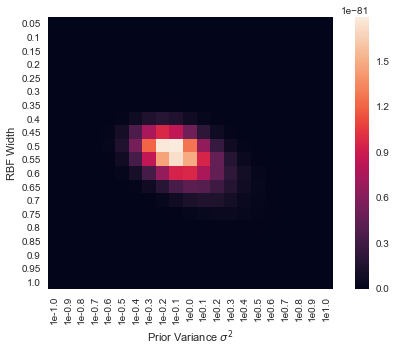

In [92]:
prior_ticks = ['1e' + str(round(i,3)) for i in np.linspace(-1, 1, 21)]
rbf_ticks = [str(round(i,4)) for i in rbf_widths]
sns.heatmap(np.exp(train_evidences), annot=False, linewidths=0, linecolor='white', cbar=True, square=True, xticklabels=prior_ticks, yticklabels=rbf_ticks)
plt.xlabel("Prior Variance $\sigma^2$")
plt.ylabel("RBF Width")
plt.savefig(str(savedir/'train_evidence.png'), bbox_inches='tight')


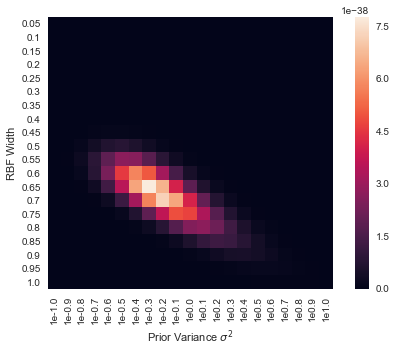

In [93]:
prior_ticks = ['1e' + str(round(i,3)) for i in np.linspace(-1, 1, 21)]
rbf_ticks = [str(round(i,4)) for i in rbf_widths]
sns.heatmap(np.exp(test_evidences), annot=False, linewidths=0, linecolor='white', cbar=True, square=True, xticklabels=prior_ticks, yticklabels=rbf_ticks)
plt.xlabel("Prior Variance $\sigma^2$")
plt.ylabel("RBF Width")
plt.savefig(str(savedir/'test_evidence.png'), bbox_inches='tight')



In [132]:
model_optim = models[9, 9]
rbf_optim = rbf_widths[9]
x_train_rbf, x_test_rbf = map(lambda x: transform_to_rbf(x, radial_basis, width=rbf_optim, add_bias_term=True),
                                     [x_train, x_test])
evidence = model_optim.calc_evidence(x_train_rbf, y_train)
print(evidence)

(-185.92790857957527, 1.7886907952399824e-81)


In [133]:
np.exp(evidence[0])

1.7886907952399824e-81

### Plots

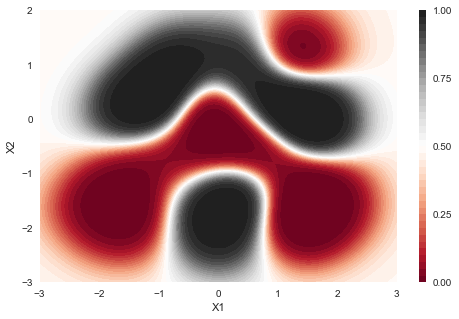

In [135]:
map_classifier = LogisticClassifier(input_size=x_train_rbf.shape[1])
map_classifier.weights = model_optim.weights_map
# map_classifier.compute_avg_ll(x_train_rbf, y_train)
plot_predictive_contourf(predict_func=lambda x: map_classifier.predict(transform_to_rbf(x, radial_basis, rbf_optim)),
                        xrange=(-3, 3), yrange=(-3, 2), res=300)
plt.savefig(str(savedir/'map_contourf_rbf05_var08.png'), bbox_inches='tight')

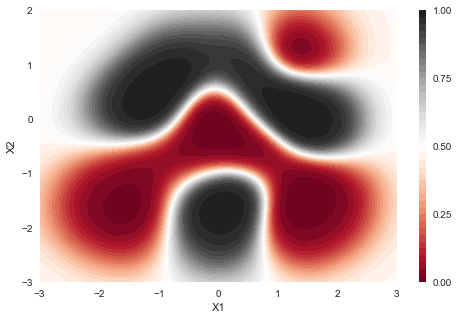

In [95]:
res = 300
# fig, axes = plt.subplots(ncols=2, figsize=(11, 4))
plot_predictive_contourf(predict_func=lambda x: model_optim.bayesian_predict(transform_to_rbf(x, radial_basis, rbf_optim)),
                         xrange=(-3, 3), yrange=(-3, 2), res=res)
plt.savefig(str(savedir/'bayes_contourf_rbf05_var08.png'), bbox_inches='tight')

In [136]:
# Calculate the confusion matrices for MAP and Bayesian models
y_probs_map = map_classifier.predict(x_test_rbf)
y_probs_bayes = model_optim.bayesian_predict(x_test_rbf)
y_pred_map = hard_prediction(y_probs_bayes)
y_pred_bayes = hard_prediction(y_probs_map)
confusion_mat_map = confusion_matrix_norm(y_test, y_pred_map)

confusion_mat_bayes = confusion_matrix_norm(y_test, y_pred_bayes)
print(confusion_mat_map, '\n\n', confusion_mat_bayes)
# And the log-likelihoods
avg_ll_map = np.mean(log_likelihood(y_test, y_probs_map))
avg_ll_bayes = np.mean(log_likelihood(y_test, y_probs_bayes))

print(f"Avg. test log-likelihood:\n  MAP: {avg_ll_map}\n  Bayes: {avg_ll_bayes}")


[[0.91588785 0.08411215]
 [0.06451613 0.93548387]] 

 [[0.91588785 0.08411215]
 [0.06451613 0.93548387]]
Avg. test log-likelihood:
  MAP: -0.22377857623681044
  Bayes: -0.22477594278057225


In [137]:
# Calculate the confusion matrices for MAP and Bayesian models
y_probs_map = map_classifier.predict(x_train_rbf)
y_probs_bayes = model_optim.bayesian_predict(x_train_rbf)
y_pred_map = hard_prediction(y_probs_bayes)
y_pred_bayes = hard_prediction(y_probs_map)

# And the log-likelihoods
avg_ll_map = np.mean(log_likelihood(y_train, y_probs_map))
avg_ll_bayes = np.mean(log_likelihood(y_train, y_probs_bayes))

print(f"Avg. train log-likelihood:\n  MAP: {avg_ll_map}\n  Bayes: {avg_ll_bayes}")

Avg. train log-likelihood:
  MAP: -0.17496560421833324
  Bayes: -0.18338801100136293
